In [ ]:
#!pip install tensorflow-gpu

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
 # Basic imports
 import numpy as np
 import cv2   #converts image into arrays
 import os 
 import random 
 import matplotlib.pyplot as plt
 import pickle
 import tensorflow as tf
 tf.random.set_seed(42) 

In [ ]:
# Importing Inception_v3

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Data set
data = '/content/drive/MyDrive/Data/'
data

'/content/drive/MyDrive/Data/'

In [ ]:
categories=glob('/content/drive/MyDrive/Data/*')
categories


['/content/drive/MyDrive/Data/Bacterial leaf blight',
 '/content/drive/MyDrive/Data/Brown spot',
 '/content/drive/MyDrive/Data/Leaf smut']

In [ ]:
# checking the dataset
for category in categories:
  folder=os.path.join(data,category)
  for img in os.listdir(folder): #this list dir will list all the files that are present in the folder
       img_path=os.path.join(folder,img)
       print(img_path)
       break

/content/drive/MyDrive/Data/Bacterial leaf blight/DSC_0388.JPG
/content/drive/MyDrive/Data/Brown spot/DSC_0329.jpg
/content/drive/MyDrive/Data/Leaf smut/DSC_0503.jpg


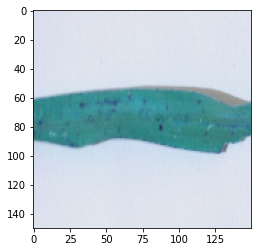

In [ ]:
# visualizing the image
IMG_SIZE=150
for category in categories:
  folder=os.path.join(data,category)
  for img in os.listdir(folder): #this list dir will list all the files that are present in the folder
       img_path=os.path.join(folder,img)
       img_arr=cv2.imread(img_path)    
       img_arr=cv2.resize(img_arr,(IMG_SIZE,IMG_SIZE)) ##cv2 converts image into array
       plt.imshow(img_arr)

In [ ]:
disease=[]
for category in categories:
  folder=os.path.join(data,category)
  label=categories.index(category)
  for img in os.listdir(folder): #this list dir will list all the files that are present in the folder
       img_path=os.path.join(folder,img)
       img_arr=cv2.imread(img_path)    #cv2 converts image into array
       img_arr=cv2.resize(img_arr,(IMG_SIZE,IMG_SIZE))
       disease.append([img_arr,label])

In [ ]:
# Splitting the data
X=[]
y=[]
for features,labels in disease:
  X.append(features)
  y.append(labels)

In [ ]:
X=np.array(X)
y=np.array(y)

In [ ]:
# Import the Inception V3 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights
IMAGE_SIZE = [150,150]
inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet',include_top=False)

In [ ]:
# don't train existing weights
for layer in inception.layers:
  layer.trainable = False

In [ ]:
# out layers - you can add more if you want
x = Flatten()(inception.output)

In [ ]:
prediction = Dense(3, activation='softmax')(x)

# create a model object
model = Model(inputs=inception.input, outputs=prediction)

In [ ]:
# view the structure of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
# compling the model
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Image Data Augmentation

In [ ]:
datagen = ImageDataGenerator(
                            preprocessing_function = preprocess_input,
                            rescale = 1./255,
                             rotation_range = 35,
                             width_shift_range = 0.2,
                             height_shift_range = 0.2,
                             shear_range = 0.2,
                             zoom_range = 0.2,
                             horizontal_flip = True,
                             fill_mode = 'nearest')

In [ ]:
# Applying the datagenerator to the dataset
i = 0
for batch in datagen.flow(X,y,batch_size = 16):
                             
  i += 1
  if i > 30:
    break

In [ ]:
# Using the early Stopping method to make better fitting
import keras
callback= keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=10,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

In [ ]:
#Training Model
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20,random_state=42)

In [ ]:
X_train_scaled = X_train /255
X_test_scaled = X_test /255

In [ ]:
from tensorflow.keras.utils import to_categorical
y_categorical_train = to_categorical(y_train,3)
y_cat_test = to_categorical(y_test,3)

In [ ]:
#training_set = X_train, y_categorical_train
#test_set = X_test, y_cat_test
#len(test_set)

In [ ]:
class_labels = ['Bacterial leaf blight','Brown spot','Leaf smut']

In [ ]:
# Fitting the Model
r=model.fit(X_train_scaled,y_categorical_train,epochs=100,batch_size=16,verbose=1,validation_data=(X_test_scaled,y_cat_test),callbacks=[callback])

Epoch 1/100
6/6 [==============================] - 11s 1s/step - loss: 2.4716 - accuracy: 0.3804 - val_loss: 3.6915 - val_accuracy: 0.4167
Epoch 2/100
6/6 [==============================] - 5s 829ms/step - loss: 1.7442 - accuracy: 0.7300 - val_loss: 1.9253 - val_accuracy: 0.6250
Epoch 3/100
6/6 [==============================] - 5s 819ms/step - loss: 0.9060 - accuracy: 0.7259 - val_loss: 1.0608 - val_accuracy: 0.7500
Epoch 4/100
6/6 [==============================] - 5s 818ms/step - loss: 0.1676 - accuracy: 0.9517 - val_loss: 1.3963 - val_accuracy: 0.5833
Epoch 5/100
6/6 [==============================] - 5s 837ms/step - loss: 0.0402 - accuracy: 0.9830 - val_loss: 1.0760 - val_accuracy: 0.7083
Epoch 6/100
6/6 [==============================] - 5s 846ms/step - loss: 0.0433 - accuracy: 0.9766 - val_loss: 0.6749 - val_accuracy: 0.7917
Epoch 7/100
6/6 [==============================] - 5s 845ms/step - loss: 0.0104 - accuracy: 1.0000 - val_loss: 0.4144 - val_accuracy: 0.8750
Epoch 8/100
6/6

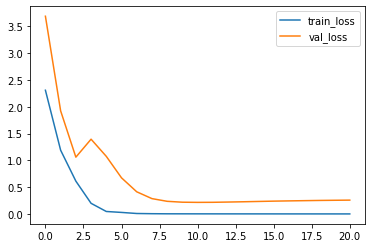

In [ ]:
# plotting the train and validation loss
plt.plot(r.history['loss'],label='train_loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()
plt.show()

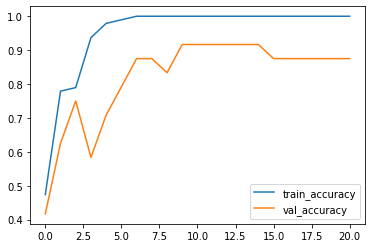

In [ ]:
# plotting the  train and validation accuracy 
plt.plot(r.history['accuracy'],label='train_accuracy')
plt.plot(r.history['val_accuracy'],label='val_accuracy')
plt.legend()
plt.show()

In [ ]:
# Evaluating the model
model.evaluate(X_test_scaled,y_cat_test)

1/1 [==============================] - 1s 965ms/step - loss: 0.2589 - accuracy: 0.8750


[0.2588672935962677, 0.875]

In [ ]:
predictions = np.argmax(model.predict(X_test_scaled), axis=-1)
predictions

array([1, 2, 0, 1, 0, 2, 1, 0, 2, 1, 0, 2, 0, 2, 1, 0, 2, 0, 1, 2, 0, 2,
       2, 1])

In [ ]:
from sklearn.metrics import classification_report
print("\033[1m\nClassification Report\n ")
print(classification_report(y_test,predictions))


Classification Report
 
              precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       0.86      0.75      0.80         8
           2       0.89      0.89      0.89         9

    accuracy                           0.88        24
   macro avg       0.87      0.88      0.87        24
weighted avg       0.87      0.88      0.87        24



<Figure size 432x288 with 0 Axes>

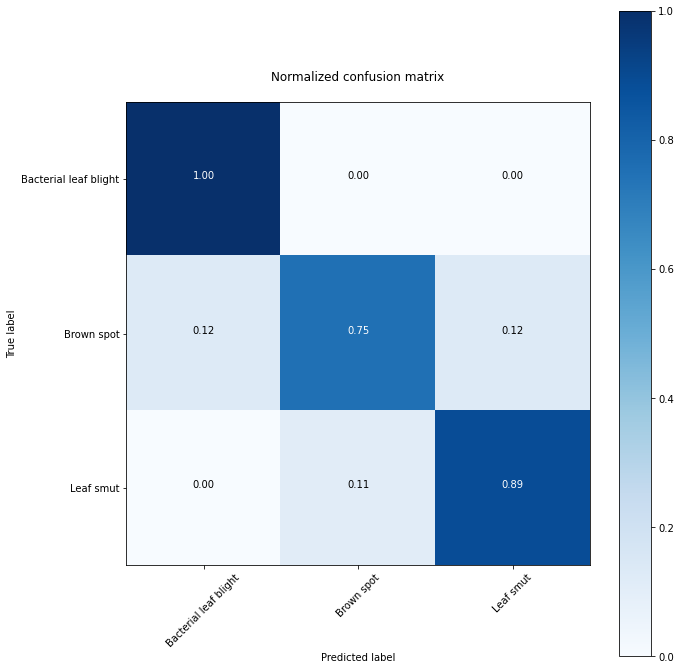

In [ ]:

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, predictions)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_labels, title='Normalized confusion matrix\n')
plt.show()
